In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import matplotlib as mpl
import utils

In [3]:
# loading the region data
with open('../../../../data/mike_working_dir/identifying_regions_data/adjusted_regions.pkl', 'rb') as f:
		regions = pickle.load(f)
with open('../../../../data/mike_working_dir/identifying_regions_data/twins_era_stats_dict_radius_regions_min_2.pkl', 'rb') as f:
		stats = pickle.load(f)

In [4]:
region_numbers = [387, 61, 202, 287, 207, 361, 137, 184, 36, 19, 9, 163, 16, 270, 194, 82,
								83, 143, 223, 44, 173, 321, 366, 383, 122, 279, 14, 95, 237, 26, 166, 86,
								62, 327, 293, 241, 107, 55, 111, 400, 401]

regions = {f'region_{region}': regions[f'region_{region}'] for region in region_numbers}

In [5]:
for region in regions:
	regions[region]['mean_lat'] = utils.getting_mean_lat(regions[region]['station'])

Loading station SOD....
Loading station IVA....
Loading station MUO....
Loading station KIR....
Loading station PEL....
Loading station SOD....
Loading station IVA....
Loading station MUO....
Loading station PEL....
Loading station LON....
Loading station THY....
Loading station NCK....
Loading station P01....
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station VYH....
Loading station LON....
Loading station THY....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station P01....
Loading station VYH....
Loading station THY....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station ZAG....
Loading station VYH....
Loading station THY....
Loading station NCK....
Loading station HRB....
Loading station BEL....
Loading station HLP....
Loading station SZC....
Loading station KLD....
Loading station MEK....
Loading station HAN....
Loading station 

In [6]:
# defining the latitude bins in degrees
lat_delimiter = 5

lat_dict = {}
for i in range(20, 90, lat_delimiter):
	lat_dict[i] = {'rsd': pd.DataFrame()}
	for region in regions:
		if regions[region]['mean_lat'] > i and regions[region]['mean_lat'] < i + lat_delimiter:
			lat_dict[i]['rsd'] = pd.concat([lat_dict[i]['rsd'], stats[region]['max_rsd'][['max_rsd', 'MLT']]], axis=0)


## going to breakdown the RSD as a function of MLT on a polar plot much like Jose's plots. Will then split it up via parts of the solar cycle, different deliniations of variables (ie. positive and negative Bz)

In [53]:
# aggregating the data into 24 hour mlt chunks
for lat in lat_dict:
	if lat_dict[lat]['rsd'].empty:
		continue
	lat_dict[lat]['rsd'].dropna(inplace=True)
	lat_dict[lat]['rsd']['MLT'] = lat_dict[lat]['rsd']['MLT'].astype(int)
	lat_dict[lat]['rsd']['MLT'].replace(24, 0, inplace=True)
	lat_dict[lat]['agg_df'] = lat_dict[lat]['rsd'].groupby('MLT').agg(['mean', 'std', 'max', 'median'])['max_rsd']

combined_aggs = pd.DataFrame()
for lat in lat_dict:
	if lat_dict[lat]['rsd'].empty:
		continue
	lat_dict[lat]['agg_df']['lat'] = lat
	combined_aggs = pd.concat([combined_aggs, lat_dict[lat]['agg_df']], axis=0)

In [119]:
# creating a meshgrid to plot the pivot table values
mltbin = np.arange(0, 24, 1)
latbin = np.arange(20, 85, 5)

print(mltbin, latbin)

arr = np.asarray(mltbin)/24.*2*np.pi
R, th = np.meshgrid(latbin, arr)

# creating the pivot table
pivot = combined_aggs.pivot_table(index='lat', columns='MLT', values='mean')

# creating a 2d array using the pivot table values and the meshgrid and filling the rest with zeros
Z = np.zeros((len(latbin), len(mltbin)), dtype=float)
for i, lat in enumerate(latbin):
	for mlt in mltbin:
		try:
			Z[i, mlt] = pivot.loc[lat, mlt]
		except:
			Z[i, mlt] = np.nan

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] [20 25 30 35 40 45 50 55 60 65 70 75 80]


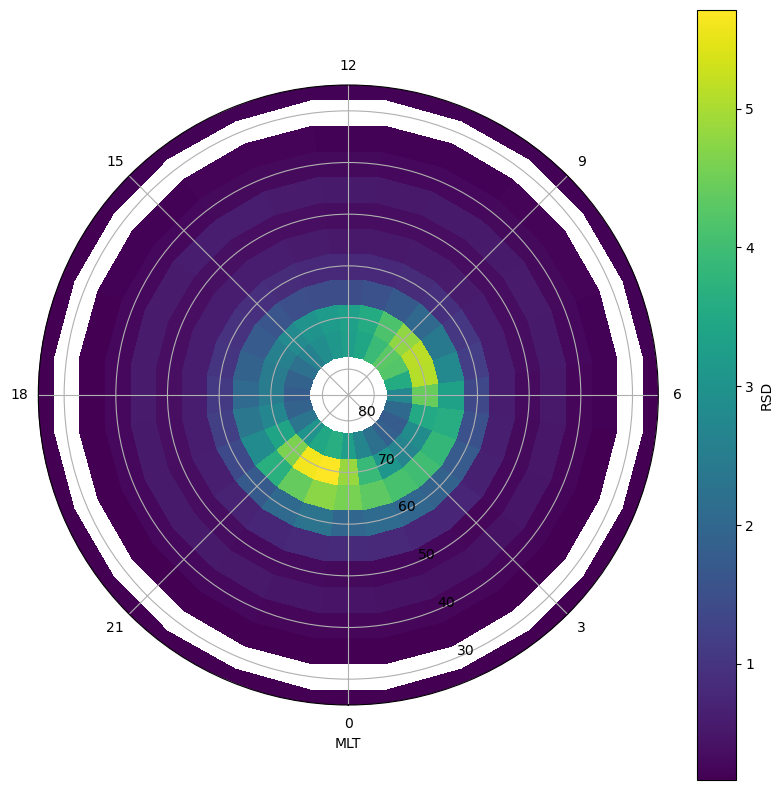

In [132]:
# plotting the heatmap using polar plot
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection='polar'))
c = ax.pcolormesh(th, R, Z.T, cmap='viridis', shading='auto')
fig.colorbar(c, ax=ax, label='RSD')
ax.set_rlim(bottom=85, top=25)
ax.set_theta_zero_location('S')
ax.set_thetagrids([theta * 45 for theta in range(360//45)], labels=[0, 3, 6, 9, 12, 15, 18, 21])
ax.set_xlabel('MLT')
plt.show()

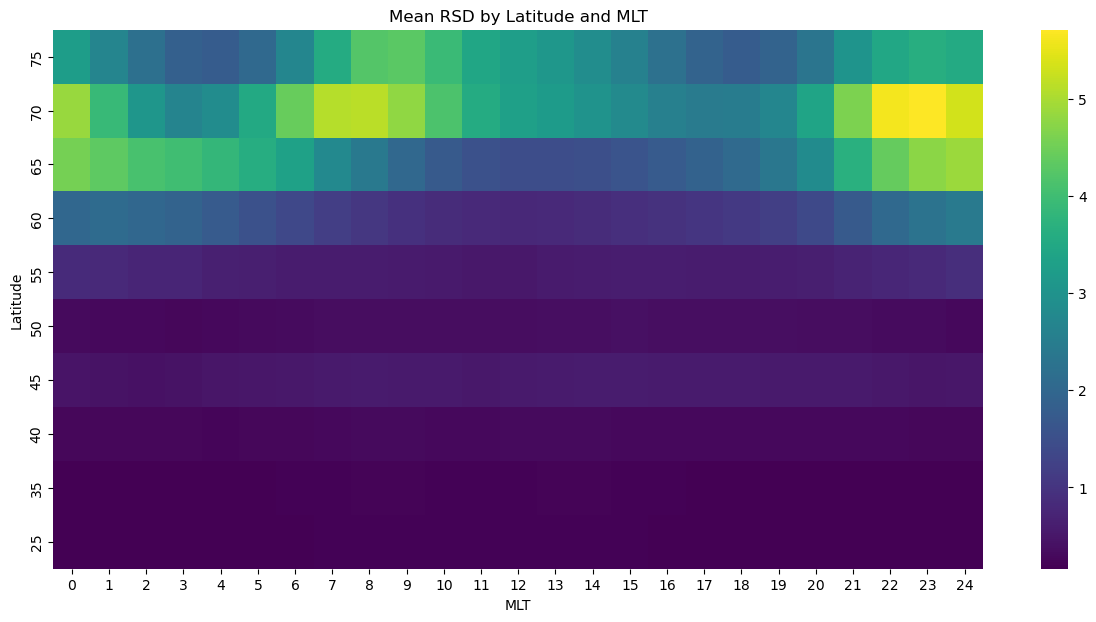

In [ ]:
# plotting a heatmap of the RSD by latitude and MLT

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(pivot, cmap='viridis', ax=ax)
ax.invert_yaxis()
ax.set_xlabel('MLT')
ax.set_ylabel('Latitude')
ax.set_title('Mean RSD by Latitude and MLT')
plt.show()